### Imports

In [1]:
import pandas as pd
import numpy as np

import random
import re
from collections import Counter
import time
import pickle
import operator
import csv

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from pymongo import MongoClient

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from sklearn.preprocessing import Normalizer
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize, WhitespaceTokenizer
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [80]:
# timing function
def timefunc(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        print(f.__name__, 'took', end - start, 'seconds')
        return result
    return f_timer

### Get pickled sample data

In [38]:
with open('master.pkl','rb') as p:
    com_trans = pickle.load(p)

In [39]:
com_trans.head()

,comment,transcript,com_tran_list,TED=1
0,Transgenderism is a mental fucking disease ! N...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[Transgenderism is a mental fucking disease ! ...,0
1,This is a wonderfully informative and hopeful ...,"Thank you so much, Chris. And it's truly a gre...",[This is a wonderfully informative and hopeful...,1
2,"As you are a Climate Change denier, I feel obl...","Thank you so much, Chris. And it's truly a gre...","[As you are a Climate Change denier, I feel ob...",1
3,if this started migrating itself into a normal...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[if this started migrating itself into a norma...,0
4,We are applauding our own absence is a powerfu...,"(Music) (Applause) Trevor Copp: When ""Dancing ...",[We are applauding our own absence is a powerf...,0


In [40]:
# df['com_tran_list'] = list(zip(df.comment, df.transcript))

In [41]:
all_comments = com_trans[['comment']]

In [42]:
comment_only = all_comments

In [43]:
comments = comment_only.copy()

In [44]:
print(comments.shape)
comments.head()

(100000, 1)


,comment
0,Transgenderism is a mental fucking disease ! N...
1,This is a wonderfully informative and hopeful ...
2,"As you are a Climate Change denier, I feel obl..."
3,if this started migrating itself into a normal...
4,We are applauding our own absence is a powerfu...


### Simple length

In [45]:
length = lambda x: len(x)
comments['length'] = comments.comment.apply(length)

In [46]:
comments.head()

,comment,length
0,Transgenderism is a mental fucking disease ! N...,59
1,This is a wonderfully informative and hopeful ...,823
2,"As you are a Climate Change denier, I feel obl...",1210
3,if this started migrating itself into a normal...,173
4,We are applauding our own absence is a powerfu...,59


In [47]:
with open('target.pkl','rb') as picklefile:
    target = pickle.load(picklefile)

In [49]:
comments['target'] = target

In [50]:
comments.columns

Index(['comment', 'length', 'target'], dtype='object')

In [51]:
comments_ = comments[['length', 'target']].copy()

In [52]:
TED = comments_[comments_['target'] == 1]
YT = comments_[comments_['target'] == 0]

In [60]:
x_l = TED.length
y_l = YT.length

/Users/THoshino/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


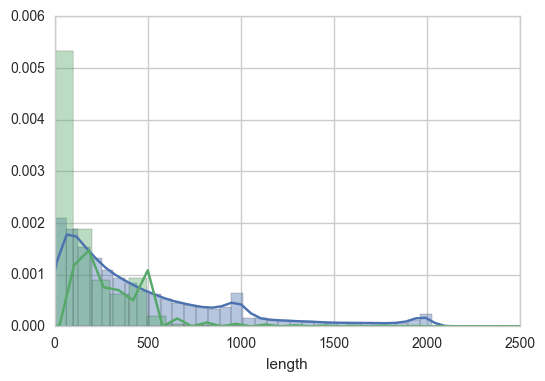

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# fig, ax = plt.subplots()
sns.set_style("whitegrid")
sns.distplot(x_l,label='TED',bins=100)
sns.distplot(y_l,label='YT', bins=100)
plt.xlim(0,2500);

### Simple sentiment

In [90]:
def text_blob_polarity(text):
    tb = TextBlob(text)
    return tb.sentiment.polarity

In [91]:
def text_blob_subjectivity(text):
    tb = TextBlob(text)
    return tb.sentiment.subjectivity

In [92]:
text_blob_subjectivity(comments.comment[4])

0.6666666666666666

In [93]:
text_blob_polarity(comments.comment[4])

0.29583333333333334

In [94]:
comments['tb_polarity'] = comments.comment.apply(text_blob_polarity)
comments['tb_subjectivity'] = comments.comment.apply(text_blob_subjectivity)

In [95]:
print(comments.shape)
comments.head()

(100000, 4)


,comment,length,tb_polarity,tb_subjectivity
0,Transgenderism is a mental fucking disease ! N...,59,-0.425000,0.500000
1,This is a wonderfully informative and hopeful ...,823,0.294444,0.536111
2,"As you are a Climate Change denier, I feel obl...",1210,-0.218056,0.416667
3,if this started migrating itself into a normal...,173,0.125000,0.550000
4,We are applauding our own absence is a powerfu...,59,0.295833,0.666667


In [96]:
with open('length_and_text_blob.pkl','wb') as p:
    pickle.dump(comments,p)

### pick up pickle

In [97]:
with open('length_and_text_blob.pkl','rb') as p:
    comments = pickle.load(p)

In [98]:
def nltk_vader_compound(text):
    sia = SentimentIntensityAnalyzer()
    score = sia.polarity_scores(text)['compound']
    return score

In [99]:
comments['nltk_vader_compound'] = comments.comment.apply(nltk_vader_compound)

In [100]:
comments_1 = comments.copy()

In [101]:
with open('length_and_sentiment.pkl','wb') as p:
    pickle.dump(comments_1,p)

### pick up pickle

In [2]:
with open('length_and_sentiment.pkl','rb') as p:
    comments_1 = pickle.load(p)

In [3]:
print(comments_1.shape)
comments_1.head()

(100000, 5)


,comment,length,tb_polarity,tb_subjectivity,nltk_vader_compound
0,Transgenderism is a mental fucking disease ! N...,59,-0.425000,0.500000,0.0000
1,This is a wonderfully informative and hopeful ...,823,0.294444,0.536111,0.9882
2,"As you are a Climate Change denier, I feel obl...",1210,-0.218056,0.416667,-0.2484
3,if this started migrating itself into a normal...,173,0.125000,0.550000,0.6523
4,We are applauding our own absence is a powerfu...,59,0.295833,0.666667,0.7096


In [4]:
with open('target.pkl','rb') as picklefile:
    target = pickle.load(picklefile)

In [7]:
comments_1['target'] = target

In [8]:
TED = comments_1[comments_1['target'] == 1]
YT = comments_1[comments_1['target'] == 0]

In [9]:
x = TED.nltk_vader_compound
y = YT.nltk_vader_compound

In [17]:
x = x[x != 0].copy()
y = y[y != 0].copy()

/Users/THoshino/anaconda/envs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


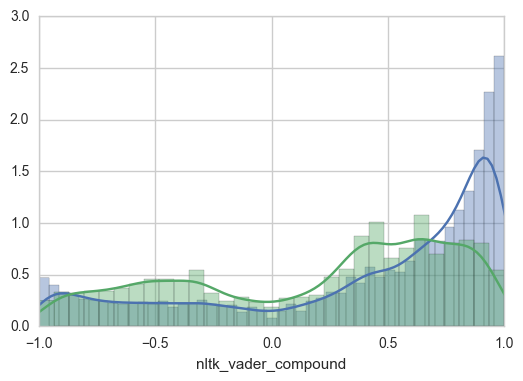

In [36]:
fig, ax = plt.subplots()
sns.set_style("whitegrid")
sns.distplot(x)
sns.distplot(y)
plt.xlim(-1,1);

### Bad words count

In [124]:
bwl_1 = pd.read_csv('bad_words_list.csv',header=None)
bwlist_1 = list(bwl_1[0])

In [125]:
bwl_2 = pd.read_csv('bad_list_fb.csv',header=None)
bwlist_2 = list(bwl_2.transpose()[0])

In [126]:
bwl_3 = pd.read_csv('bad_list_google.csv',header=None)
bwlist_3 = list(bwl_3[0])

In [127]:
bwl_4 = pd.read_csv('bad_list_christian.csv',header=None)
bwlist_4 = list(bwl_4[0])

In [128]:
bwlist = set(bwlist_1 + bwlist_2 + bwlist_3 + bwlist_4)
len(bwlist)

1542

In [129]:
def bad_word_counter(text):
    tokens = word_tokenize(text)
    counter = 0
    for i in tokens:
        if i in bwlist:
            counter += 1
    return counter

In [130]:
comments_2 = comments_1.copy()

In [131]:
comments_2['troll'] = comments_2.comment.apply(bad_word_counter)

In [132]:
print(comments_2.shape)
comments_2.head()

(100000, 7)


,comment,length,tb_polarity,tb_subjectivity,nltk_vader_compound,target,troll
0,Transgenderism is a mental fucking disease ! N...,59,-0.425000,0.500000,0.0000,0,1
1,This is a wonderfully informative and hopeful ...,823,0.294444,0.536111,0.9882,1,1
2,"As you are a Climate Change denier, I feel obl...",1210,-0.218056,0.416667,-0.2484,0,0
3,if this started migrating itself into a normal...,173,0.125000,0.550000,0.6523,0,0
4,We are applauding our own absence is a powerfu...,59,0.295833,0.666667,0.7096,0,0


In [133]:
comments_2.troll.value_counts()

0     90583
1      6949
2      1587
3       498
4       181
5        80
6        51
7        20
8        14
9         9
11        9
10        5
12        5
13        2
15        2
19        1
14        1
16        1
18        1
41        1
Name: troll, dtype: int64

In [134]:
with open('all_simple_features.pkl','wb') as p:
    pickle.dump(comments_2,p)

### pick up pickle

In [135]:
with open('all_simple_features.pkl','rb') as p:
    comments_2 = pickle.load(p)

In [136]:
# pronoun usage

you_re = re.compile("[yY]ou")
they_re = re.compile("[tT]hem|[tT]hey")
I_re = re.compile("I\s")

def get_first_person_per(ts):
    '''Gets percentage of first person pronoun usage (I)'''
    yous = len(re.findall(you_re, ts))
    Is = len(re.findall(I_re, ts))
    theys = len(re.findall(they_re, ts))
    total = yous + Is + theys
    if total == 0:
        total = 1
    return float(Is)/total

def get_third_person_per(ts):
    '''Gets percentage of first person pronoun usage (I)'''
    yous = len(re.findall(you_re, ts))
    Is = len(re.findall(I_re, ts))
    theys = len(re.findall(they_re, ts))
    total = yous + Is + theys
    if total == 0:
        total = 1
    return float(theys)/total

# df['first_per'] = df.transcripts.apply(get_first_person_per)
# df['third_per'] = df.transcripts.apply(get_third_person_per)

In [137]:
# percent question marks, 
def get_punc_per(ts, mark='?'):
    punc_re = re.compile("[\.\?\!]")
    total_punc = float(len(re.findall(punc_re, ts)))
    if total_punc == 0:
        total_punc = 1
    return ts.count(mark)/total_punc

In [138]:
comments_2['first_p'] = comments_2.comment.apply(get_first_person_per)
comments_2['third_p'] = comments_2.comment.apply(get_third_person_per)
comments_2['questions'] = comments_2.comment.apply(get_punc_per)

In [139]:
comments_2.shape

(100000, 10)

In [140]:
comments_2.head()

,comment,length,tb_polarity,tb_subjectivity,nltk_vader_compound,target,troll,first_p,third_p,questions
0,Transgenderism is a mental fucking disease ! N...,59,-0.425000,0.500000,0.0000,0,1,0.0,0.000000,0.0
1,This is a wonderfully informative and hopeful ...,823,0.294444,0.536111,0.9882,1,1,0.0,0.333333,0.0
2,"As you are a Climate Change denier, I feel obl...",1210,-0.218056,0.416667,-0.2484,0,0,0.5,0.000000,0.0
3,if this started migrating itself into a normal...,173,0.125000,0.550000,0.6523,0,0,0.0,1.000000,0.0
4,We are applauding our own absence is a powerfu...,59,0.295833,0.666667,0.7096,0,0,0.0,0.000000,0.0


In [143]:
with open('all_all_simple_features.pkl','wb') as p:
    pickle.dump(comments_2,p)

### pick up pickle

In [144]:
with open('all_all_simple_features.pkl','rb') as p:
    comments_2 = pickle.load(p)